In [1]:
import os
import sys
home_dir = "../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.pickle_utils as pickle_utils
from utils.dicts import colors_dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
root = "/usr/projects/pyDNA_EPBD/pyDNA_EPBD_inputs_outputs/"
simulation_outs_dir = root+"outputs_simulation/qfactor_7snps_500iters/qfactor_seqs/"

In [3]:
# ci = 0.95 * np.std(flip_wt, axis=0)# / np.mean(flip_wt, axis=0) # https://www.tutorialspoint.com/how-to-visualize-95-confidence-interval-in-matplotlib
# ci = 1.96 * np.std(flip_wt, axis=0)/np.sqrt(len(flip_wt)) # https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python

def plot_avg_flip(flip_wt, flip_mt, rsid, mutation_pos):
    out_dir = home_dir+f"plots/snps_flipping_profiles_with_qfactors/"
    os.makedirs(out_dir, exist_ok=True)
    
    plt.clf()
    # fig, ax = plt.subplots(figsize=(10, 5))
        
    flip_wt_avg = flip_wt.mean(axis=0)
    flip_mt_avg = flip_mt.mean(axis=0)

    plt.plot(flip_wt_avg, label=f"Avg flipping {rsid}-wt", color=colors_dict["wild_type"], marker=".", linestyle='--', markersize=5, linewidth=.5, markerfacecolor='none')
    plt.plot(flip_mt_avg, label=f"Avg flipping {rsid}-mt", color=colors_dict["mutant_type"], marker=".", linestyle='--', markersize=5, linewidth=.5, markerfacecolor='none')

    x = range(flip_wt_avg.shape[0])
    ci_wt = 1.96 * np.std(flip_wt, axis=0) / np.sqrt(len(flip_wt))
    plt.fill_between(x, (flip_wt_avg-ci_wt), (flip_wt_avg+ci_wt), color='blue', alpha=0.3, label=f"95% CI {rsid}-wt")

    ci_mt = 1.96 * np.std(flip_mt, axis=0) / np.sqrt(len(flip_mt))
    plt.fill_between(x, (flip_mt_avg-ci_mt), (flip_mt_avg+ci_mt), color='red', alpha=0.3, label=f"95% CI {rsid}-mt")

    ticks_labels_fontsize=15
    plt.axvline(x = mutation_pos, color=colors_dict["mut_pos"], linestyle='--')
    plt.xlabel("Base pair index", fontsize=ticks_labels_fontsize)
    plt.ylabel("Average flipping profile", fontsize=ticks_labels_fontsize)
    plt.yticks(fontsize=ticks_labels_fontsize)
    plt.xticks(fontsize=ticks_labels_fontsize)
    legend = plt.legend(fontsize=ticks_labels_fontsize, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=1, fancybox=True, shadow=False, edgecolor="black")
    legend.get_frame().set_alpha(0.3)
    # legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    # plt.show()
    plt.savefig(out_dir+f"{rsid}_flips.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)

In [4]:
from scipy.stats import ks_2samp
def compute_qfactor(flip_wt, flip_mt):
    q_val=[]
    for i in range(flip_wt.shape[1]):
        a, p_Val=ks_2samp(flip_wt.T[i], flip_mt.T[i])
        q_val.append(p_Val)

    # print(q_val[100])
    q_factor=-np.log10(q_val)
    # print(q_factor)
    return q_factor

def plot_qfactor(q_factor, rsid, mutation_pos):
    out_dir = home_dir+f"plots/snps_flipping_profiles_with_qfactors/"
    os.makedirs(out_dir, exist_ok=True)
    
    ticks_labels_fontsize = 15
    
    plt.clf()
    # fig, ax = plt.subplots(figsize=(10, 5))
    # plt.plot(q_factor, "o-", c="r", alpha=.5)
    plt.axvline(x = mutation_pos, color=colors_dict["mut_pos"], linestyle='--')
    plt.plot(q_factor, color=colors_dict["qfactor"], marker=".", linestyle='--', markersize=5, linewidth=.5, markerfacecolor='none')
    plt.xlabel("Base pair index", fontsize=ticks_labels_fontsize)
    plt.ylabel("q-factor (-log10(qValues))", fontsize=ticks_labels_fontsize)
    plt.ylim([0, 45])
    plt.yticks(fontsize=ticks_labels_fontsize)
    plt.xticks(fontsize=ticks_labels_fontsize)
    # plt.show()
    plt.savefig(out_dir+f"{rsid}_qfactors.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)


In [5]:
def get_outputs(seq_name):
    out_filepath = simulation_outs_dir+f"{seq_name}.pkl"

    outputs = pickle_utils.load_pickle(out_filepath)
    # print(f"\t---{seq_name}---")
    # for key, value in outputs.items():
    #     print("\t", key, outputs[key].shape)# utils.get_dimension(outputs[key]))
    # print()
    return outputs

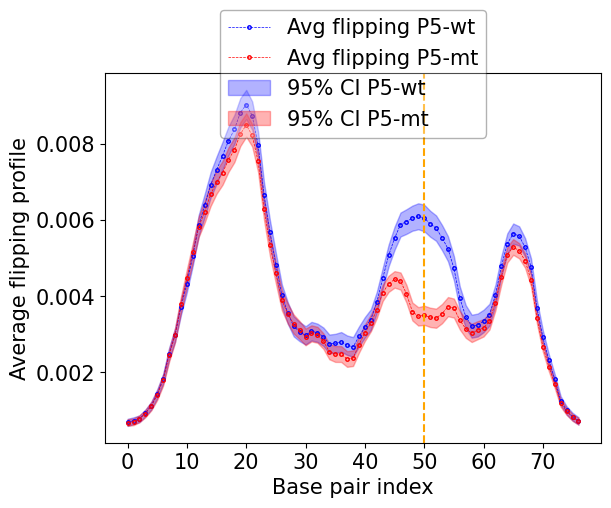

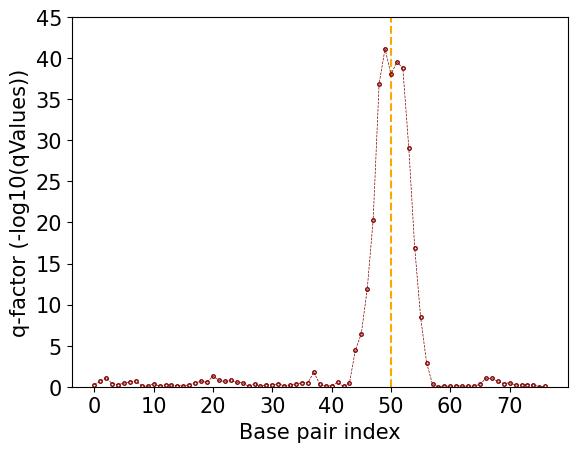

In [7]:
rsids_mutPos_df = pd.read_csv(home_dir+"examples/qfactor_7snps/id_mutPos.txt", sep=" ")
for row in rsids_mutPos_df.itertuples():

    rsid = row.id #rs12946510, rs72974222
    mut_pos = row.zero_indexed_mut_position

    wt_outputs = get_outputs(f"{rsid}_wt")
    mt_outputs = get_outputs(f"{rsid}_mt")

    n_steps_after_preheating = 80000
    norm = 1.00 / (n_steps_after_preheating)

    flip_wt = np.array(wt_outputs["flip_verbose"][:,:,3]) * norm
    flip_mt = np.array(mt_outputs["flip_verbose"][:,:,3]) * norm
    # print(flip_wt.shape, flip_mt.shape)

    plot_avg_flip(flip_wt, flip_mt, rsid, mut_pos)
    qfactor = compute_qfactor(flip_wt, flip_mt)
    plot_qfactor(qfactor, rsid, mut_pos)
    # break

In [8]:
def get_qfactors_at_muPos(df):
    qfactors_at_muPos = []
    for row in df.itertuples():
        # print(row.id, row.zero_indexed_mut_position)

        rsid = row.id #rs12946510, rs72974222
        mut_pos = row.zero_indexed_mut_position

        wt_outputs = get_outputs(f"{rsid}_wt")
        mt_outputs = get_outputs(f"{rsid}_mt")

        n_steps_after_preheating = 80000
        norm = 1.00 / (n_steps_after_preheating)

        flip_wt = np.array(wt_outputs["flip_verbose"][:,:,3]) * norm
        flip_mt = np.array(mt_outputs["flip_verbose"][:,:,3]) * norm
        # print(flip_wt.shape, flip_mt.shape)

        qfactor = compute_qfactor(flip_wt, flip_mt)
        print(rsid, qfactor[mut_pos])
        qfactors_at_muPos.append(qfactor[mut_pos])
    return qfactors_at_muPos


df = rsids_mutPos_df
tfAffectingSNPs_df = df[df["tfb_or_ctrl"]=="tfb"]
qfactors_at_muPos_for_tfAffectingSNPs = get_qfactors_at_muPos(tfAffectingSNPs_df)

controlSNPS_df = df[df["tfb_or_ctrl"]!="tfb"]
qfactors_at_muPos_for_controlSNPs = get_qfactors_at_muPos(controlSNPS_df)

P5 38.01990744366228
rs3823752 31.132969855998745
rs12946510 26.842748419277243
rs1108842 25.28202692673187
rs2299319 10.284596344882232
rs72692900 9.900112041654914
rs7612511 9.900112041654914
rs72974222 1.5376624921369857


4


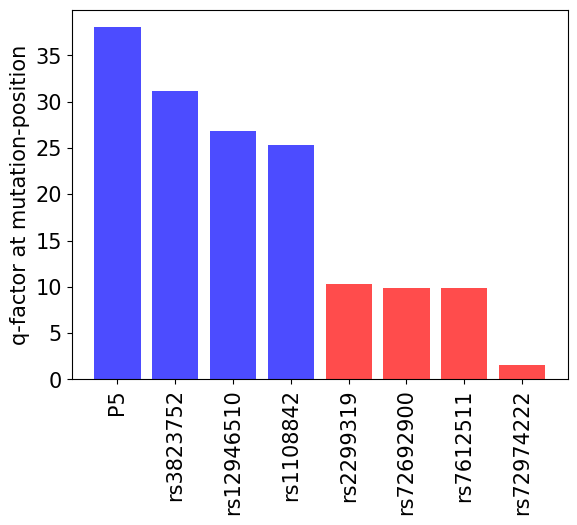

In [9]:
print(tfAffectingSNPs_df.shape[0])
plt.bar(range(tfAffectingSNPs_df.shape[0]), qfactors_at_muPos_for_tfAffectingSNPs, color="blue", alpha=0.7)
plt.bar(range(tfAffectingSNPs_df.shape[0], tfAffectingSNPs_df.shape[0]+controlSNPS_df.shape[0]), qfactors_at_muPos_for_controlSNPs, color="red", alpha=0.7)
plt.xticks(range(tfAffectingSNPs_df.shape[0]+controlSNPS_df.shape[0]), tfAffectingSNPs_df["id"].to_list()+controlSNPS_df["id"].to_list() , rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("q-factor at mutation-site", fontsize=15)

plt.show()